In [24]:
%matplotlib inline

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import commonfunctions as cf

# Collaborative filtering méthode

## Etape préliminaire : filtrer sur les exemplaires de la BU SJA et anonymiser les identifiants système des lecteurs dans le fichier source

In [ ]:
df = pd.read_csv('data/01_raw/sja_tous_prets.csv', sep = '	')
df.shape ## 488 273 lignes

On filtre sur les exemplaires localisés à la BU SJA prêtés depuis 2015 et sur les prêts hors enregistrements de prêt sur les compte des BU pour la gestion du transit inter-BU

In [72]:
df = df[df['Id. Bibliothèque exemplaire actuelle'] == 'SJA']
df.shape ## 61 045 lignes

(61045, 20)

In [73]:
df = df[df['Année Prêt'] >= 2015]
df.shape ## 31 641 ligne

(31641, 20)

In [75]:
df = df[df['ID Lecteur'].str.contains("ID")]
df.shape ## 26 241 lignes

(26241, 20)

Id anonymisés dans une nouvelle colonne

In [76]:
labels, uniques =  pd.factorize(df['ID Lecteur'])
labels = ['person_'+str(l) for l in labels]
df['id_lecteur'] = labels

Suppression de la colonne initiale des Id lecteurs

In [77]:
df.drop(['ID Lecteur'], axis=1, inplace=True)

Et on sauvegarde dans un nouveau fichier

In [ ]:
df.to_csv("data/02_intermediate/prets_sja_anonymized.csv", sep = ';', index=False, encoding='utf8')

## Nettoyage/analyse stats des données

In [26]:
df.head(1)

,Nbre de Prêts,Jour Prêt,Date Prêt,Année Prêt,Desc Statut Lecteur,ID Type Lecteur,Id. Bibliothèque exemplaire actuelle,Date Publication,ID Type Matériel,Desc Cote Principale,Desc Cote Début,No Doc,Titre,Desc2,Auteur,Editeur,Desc4,No de Notice BIB,Mois Prêt,id_lecteur
0,1,Lundi,2015-05-04 00:00:00,2015,[Services] Doctorant,DO,SJA,2013,L,616 KB,616,337328,"Hépato-gastro-entérologie, chirurgie digestive",NaN,"Zeitoun, Jean-David",Éd. Vernazobres-Grego,PPN172794439,337328,5,person_0


### Suppression et renommage de colonnes

In [27]:
df.drop(['Date Prêt', 'Desc Statut Lecteur', 'Id. Bibliothèque exemplaire actuelle', 'ID Type Matériel', 'Desc Cote Principale', 'No Doc', 'Desc2', 'Auteur', 'Editeur'], axis = 1, inplace = True)

In [5]:
df.head(1)

,Nbre de Prêts,Jour Prêt,Année Prêt,ID Type Lecteur,Date Publication,Desc Cote Début,Titre,Desc4,No de Notice BIB,Mois Prêt,id_lecteur
0,1,Lundi,2015,DO,2013,616,"Hépato-gastro-entérologie, chirurgie digestive",PPN172794439,337328,5,person_0


In [28]:
df.columns = ['nb_pret', 'jour_pret', 'annee_pret', 'type_lecteur', 'date_pub', 'indice', 'titre', 'ppn', 'num', 'mois_pret', 'id_lecteur']

In [29]:
df.describe(include='all')

,nb_pret,jour_pret,annee_pret,type_lecteur,date_pub,indice,titre,ppn,num,mois_pret,id_lecteur
count,26241.000000,26241,26241.000000,26241,26241.000000,26241.000000,26241,26236,26241.000000,26241.000000,26241
unique,NaN,7,NaN,19,NaN,NaN,4192,5760,NaN,NaN,4712
top,NaN,Mardi,NaN,M2,NaN,NaN,Management,PPN183659562,NaN,NaN,person_119
freq,NaN,4615,NaN,9249,NaN,NaN,348,112,NaN,NaN,375
mean,1.005068,NaN,2016.637438,NaN,2009.929500,597.509965,NaN,NaN,268615.185664,5.879692,NaN
std,0.078652,NaN,1.323489,NaN,14.042012,139.549473,NaN,NaN,125553.002458,3.615269,NaN
min,1.000000,NaN,2015.000000,NaN,0.000000,1.000000,NaN,NaN,146.000000,1.000000,NaN
25%,1.000000,NaN,2015.000000,NaN,2008.000000,616.000000,NaN,NaN,126690.000000,3.000000,NaN
50%,1.000000,NaN,2017.000000,NaN,2012.000000,657.000000,NaN,NaN,325435.000000,5.000000,NaN
75%,1.000000,NaN,2018.000000,NaN,2014.000000,658.000000,NaN,NaN,354876.000000,10.000000,NaN


### Gestion des valeurs nulles et des outliers

In [30]:
cf.missing_zero_values_table(df)

Your selected dataframe has 11 columns and 26241 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
ppn,0,5,0.0,5,0.0,object


#### PPN

In [31]:
df.num[d.ppn.isnull()]

11135    421028
13870    425433
14087    421190
19611    421028
24861    424619
Name: num, dtype: int64

On supprime aussi dans ce dataframe les exemplaires dont les ppn sont vides

In [32]:
df.dropna(subset=['ppn'], inplace = True)

In [33]:
df.shape ## 26 236 lignes

(26236, 11)

#### Dates de publication

In [34]:
df.date_pub.unique()

array([2013, 2008, 2016, 2011, 2001, 2015, 2014, 2012, 2018, 2007, 1999,
       1994, 2017, 2005, 2009, 1991, 1974, 2004, 2010, 1995, 1979, 1972,
       2006, 1997, 1996, 2000, 2002, 1987, 1978, 1951, 1973, 2003, 1993,
       1950, 1982, 2019, 1992, 1990, 1989, 1985, 1984, 1986, 1983, 1998,
       1967, 1969, 1952, 1975, 1976, 1962, 1981, 1970, 1988, 1954, 1971,
       1977, 1968, 1966, 1958, 1939, 1961, 1935, 1960, 1933, 1980, 1949,
       1959, 1938, 1965, 1964, 1955], dtype=int64)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e03baf06d8>,
 'caps': [<matplotlib.lines.Line2D at 0x1e03baf0d68>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e03baf02b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e03bb00438>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e03bb00780>],
 'means': []}

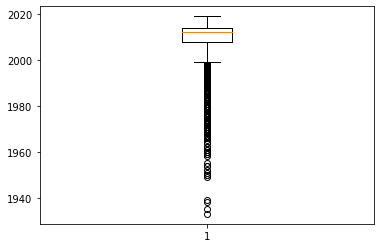

In [35]:
plt.boxplot(df['date_pub'])

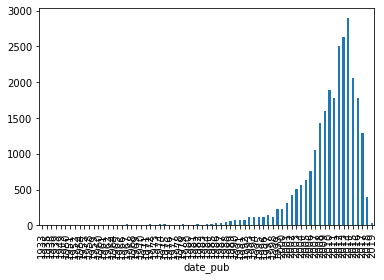

In [21]:
df.groupby('date_pub')['nb_pret'].sum().plot.bar()
plt.rcParams["figure.figsize"] = (24, 9)
plt.tick_params(axis='x', labelrotation=90)
## nb de prets selon la date de pub des docs, à rapprocher du même graphique sur les collections

#### Années de prêt

In [88]:
df.annee_pret.unique()

array([2015, 2017, 2016, 2018, 2019], dtype=int64)

In [22]:
df.annee_pret.value_counts()

2015    6920
2016    5959
2017    5821
2018    4797
2019    2739
Name: annee_pret, dtype: int64

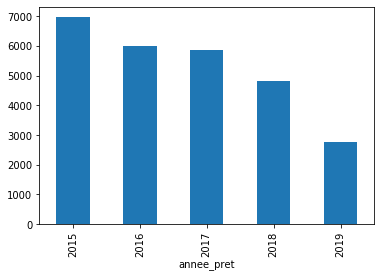

In [36]:
df.groupby('annee_pret')['nb_pret'].sum().plot.bar()
plt.rcParams["figure.figsize"] = (24, 9)
plt.tick_params(axis='x', labelrotation=90)
## nb de prêts par année

#### Mois de prêt

In [117]:
df.mois_pret.unique()

array([ 5,  6,  3, 11,  9,  4,  2,  1, 10,  7, 12,  8], dtype=int64)

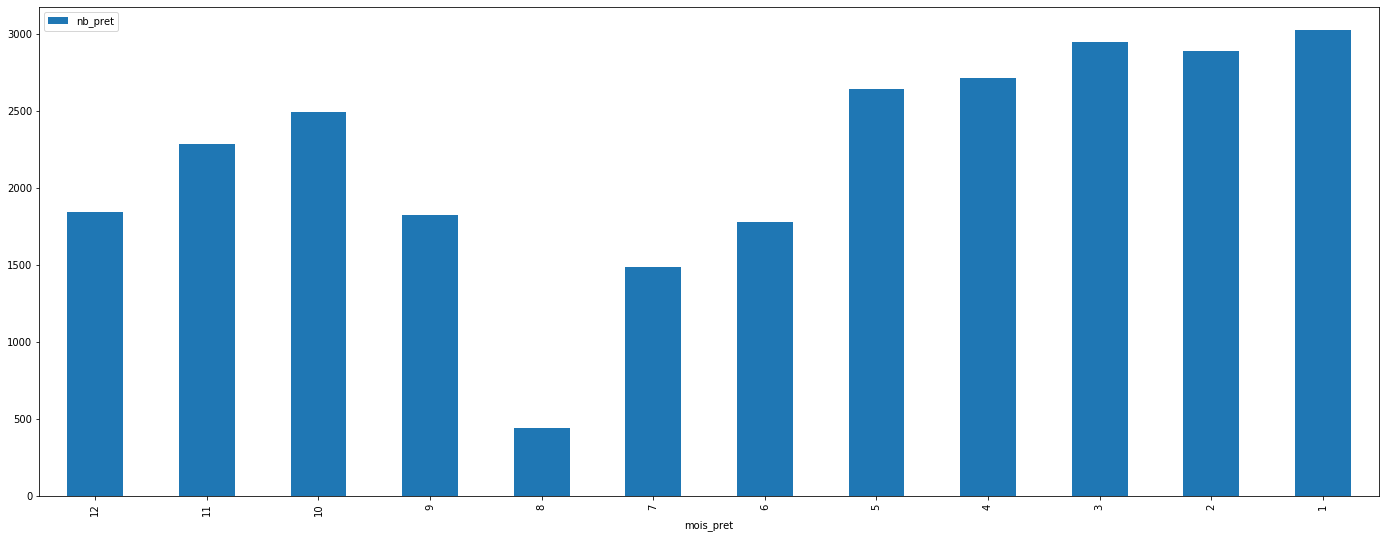

In [37]:
df.groupby('mois_pret').agg({'nb_pret':sum}).sort_values('mois_pret',ascending=False).plot.bar()
plt.rcParams["figure.figsize"] = (24, 9)
plt.tick_params(axis='x', labelrotation=90)
## nb de prêts par mois

#### Jour de prêt

In [103]:
df.jour_pret.unique()

array(['Lundi', 'Vendredi', 'Mercredi', 'Samedi', 'Jeudi', 'Mardi',
       'Dimanche'], dtype=object)

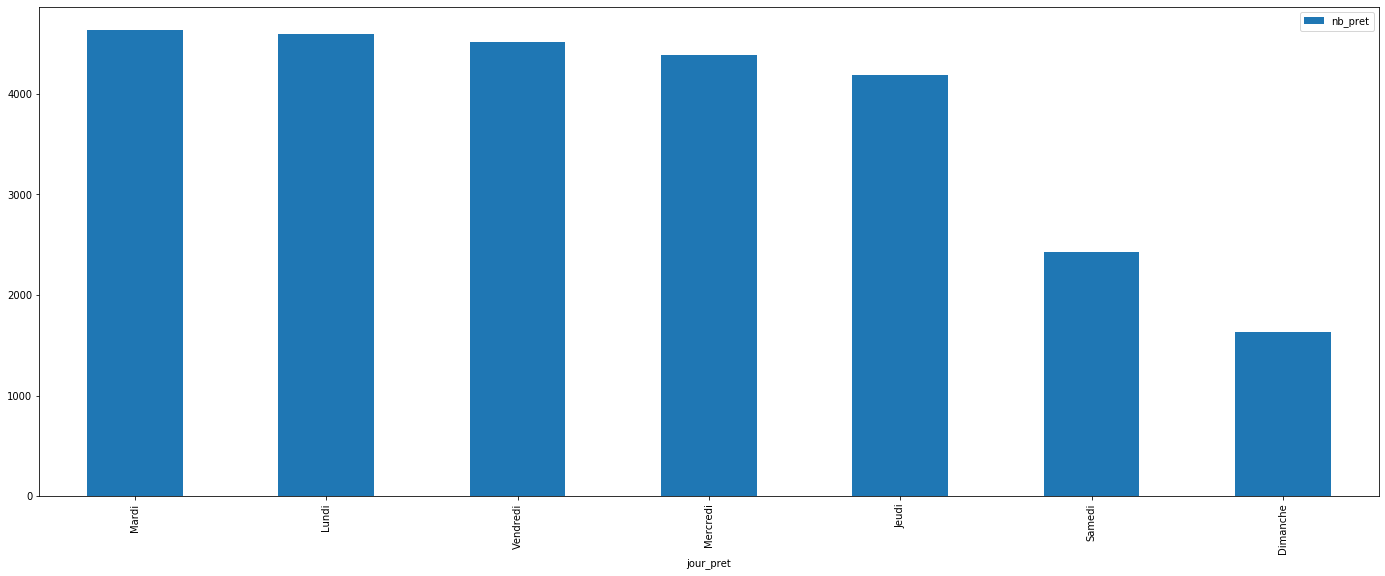

In [38]:
df.groupby('jour_pret').agg({'nb_pret':sum}).sort_values('nb_pret',ascending=False).plot.bar()
plt.rcParams["figure.figsize"] = (24, 9)
plt.tick_params(axis='x', labelrotation=90)
##nb de prêts par jour de la semaine

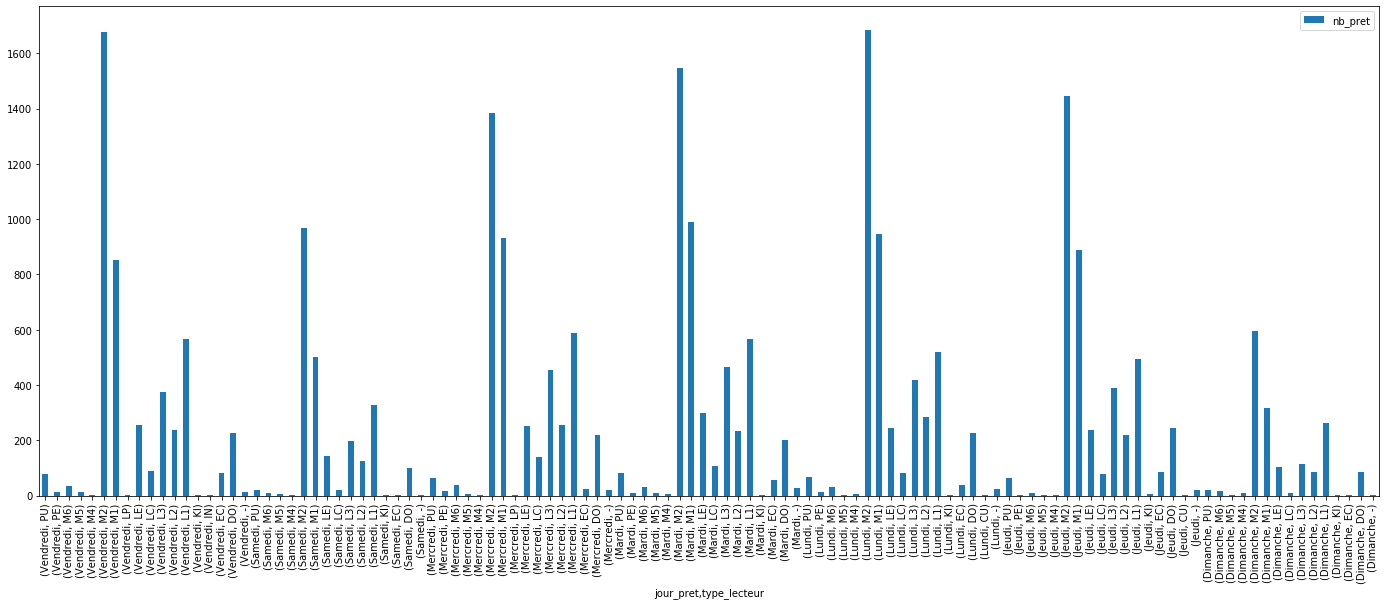

In [116]:
df.groupby(['jour_pret','type_lecteur']).agg({'nb_pret':sum}).sort_values(['jour_pret','type_lecteur'],ascending=False).plot.bar()
plt.rcParams["figure.figsize"] = (24, 9)
plt.tick_params(axis='x', labelrotation=90)
## nb de prêts par jour de la semaine selon le type de lecteur

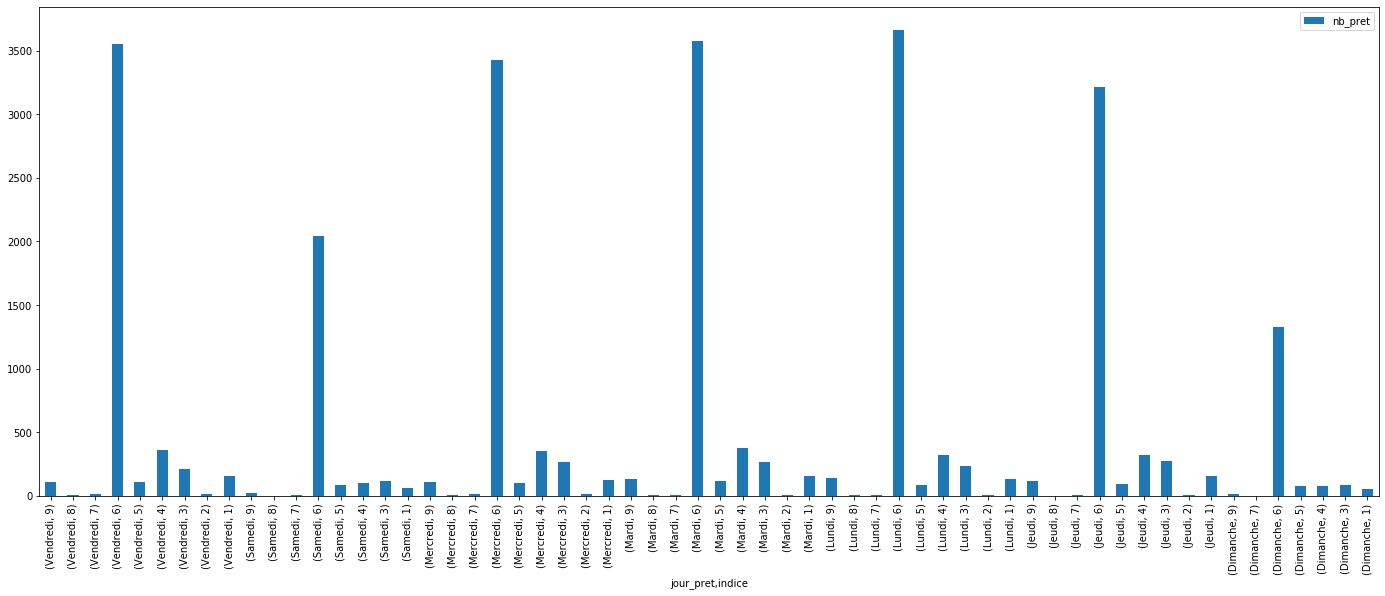

In [124]:
df['indice'] = df['indice'].astype(str).str[0]
df.groupby(['jour_pret','indice']).agg({'nb_pret':sum}).sort_values(['jour_pret','indice'],ascending=False).plot.bar()
plt.rcParams["figure.figsize"] = (24, 9)
plt.tick_params(axis='x', labelrotation=90)
## nb de prêts par jour selon la dscipline

#### Types de lecteurs

In [7]:
df.type_lecteur.unique()

array(['DO', 'L3', 'M2', 'LC', 'L1', 'M1', 'L2', 'M5', 'M6', 'EC', 'PU',
       'PE', 'LE', '-', 'M4', 'LP', 'IN', 'CU', 'KI'], dtype=object)

In [ ]:
df.loc[df.type_lecteur == '-'] ## 102 lignes

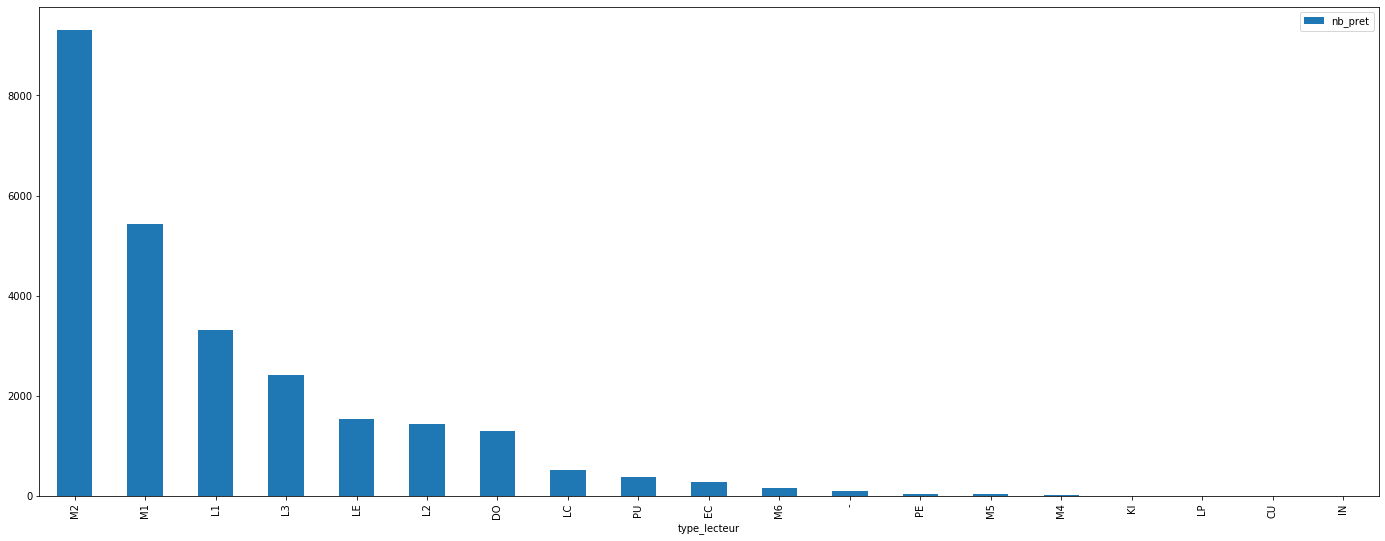

In [39]:
## nb de prêts par type de lecteurs
df.groupby('type_lecteur').agg({'nb_pret':sum}).sort_values('nb_pret',ascending=False).plot.bar()

#### indices de cotes

In [12]:
df.indice.unique()

array([616, 375, 658, 657, 370, 376, 910, 610, 153, 152, 420, 950,   1,
       612, 800, 540, 500, 618, 576, 461, 371, 973, 158,  39, 374, 362,
       421, 363, 379, 965, 512, 611, 580,  25, 930, 510, 411, 144, 378,
       155, 450, 519, 126, 659,   4, 940,   5,  70, 509, 156, 428, 944,
        34, 969, 550, 111, 809, 891, 460, 515, 128, 702, 572, 365, 570,
       577, 981, 390, 490, 914, 621, 840, 398, 400, 447, 530, 366, 191,
       121, 417, 451, 150,  27, 364, 531, 537, 980, 457, 808, 701, 796,
       440, 909, 193, 414, 391, 780, 190, 408,  30, 706, 200, 410, 915,
       791, 401, 972, 395, 967, 590, 449, 427, 415, 425, 970, 919, 394,
       620, 720, 516, 372, 110, 496, 941, 959, 430, 801, 966, 506, 535,
       956, 591, 920, 907,  28, 443, 192, 553, 536, 146, 990, 445, 960,
       833, 961, 993, 194, 154, 916, 539, 514, 917, 599, 746, 441, 770,
       797, 149, 839, 491, 497, 382, 630, 995, 195, 520, 115, 709, 727,
       409, 848, 189], dtype=int64)

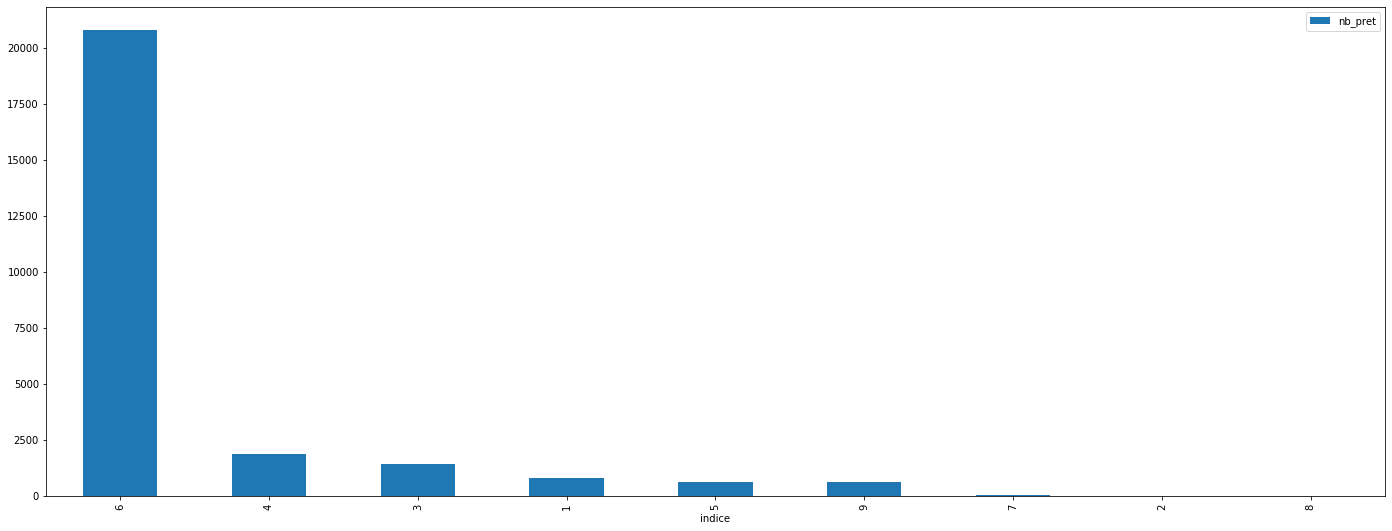

In [40]:
## nb de prêts par indices de cote (seulement les grandes catégories)
df['indice'] = df['indice'].astype(str).str[0]
df.groupby('indice').agg({'nb_pret':sum}).sort_values('nb_pret',ascending=False).plot.bar()

## Sauvegarde

In [41]:
df.to_csv("data/03_primary/prets_sja_anonymiosed_ready.csv", sep = ';', index=False, encoding='utf8')

## Environnement Python-Neo4j

In [ ]:
## plusieurs drivers python existent pour se connecter à une bdd Neo4j, on choisit py2neo
pip install py2neo

In [11]:
from py2neo import Graph
## par exemple pour une connexion sur une instance locale Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "Superadmin"))

On teste la connexion avec une requête Cypher

In [ ]:
graph.run("CALL apoc.help('apoc')").to_table()

La requête Cypher pour charger les données

LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/gegedenice/primo-recommender-system/master/SimilarityModel/data/collaborative-filtering_complete.csv' as row FIELDTERMINATOR ';' MERGE (g:Groupe {nom:row.type_lecteur}) MERGE (l:Lecteur {id:row.id_lecteur}) MERGE (d:Doc {num:row.num,titre:row.titre}) MERGE (disc:Disc {indice:row.indice}) WITH row,g,l,d,disc MATCH (g:Groupe),(l:Lecteur) WHERE g.nom = row.type_lecteur AND l.id = row.id_lecteur MERGE (l)-[:IN_GROUP]->(g) WITH row,l,d,disc MATCH (l:Lecteur),(d:Doc) WHERE l.id = row.id_lecteur AND d.num = row.num MERGE (l)-[:HAS_LOAN]->(d) WITH row,d,disc MATCH (d:Doc),(disc:Disc) WHERE d.num = row.num AND disc.indice = row.indice MERGE (d)-[:HAS_DISC]->(disc) RETURN *

Apercu du graphe

In [14]:
import networkx as nx

C:\Users\geoffroy\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\geoffroy\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


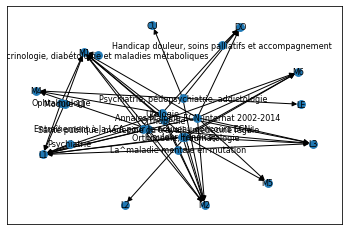

<Figure size 864x864 with 0 Axes>

In [15]:
df = graph.run("MATCH (g:Groupe)<-[:IN_GROUP]-(l:Lecteur)-[:HAS_LOAN]->(d:Doc)-[:HAS_DISC]->(disc:Disc) RETURN g.nom,d.titre LIMIT 100").to_data_frame()
G=nx.DiGraph()   
G.add_nodes_from(list(set(list(df.iloc[:,0]) + list(df.iloc[:,1]))))
tuples = [tuple(x) for x in df.values] 
G.add_edges_from(tuples)
G.number_of_edges()
nx.draw_networkx(G,node_size=60,font_size=8)
plt.figure(3,figsize=(12,12)) 
plt.show()

### Requête pour la fonction de recommandations

In [17]:
import json

In [18]:
num = "306650"
query = """
MATCH (d1:Doc {num: '"""+num+"""'})<-[:HAS_LOAN]-(l:Lecteur)-[:HAS_LOAN]->(d2:Doc) 
RETURN d2.titre AS recommendation, COUNT(*) AS usersWhoAlsoLoaned 
ORDER BY usersWhoAlsoLoaned DESC LIMIT 10
"""
json.dumps(graph.run(query).data())

'[{"recommendation": "L\'analyse du travail en psychologie ergonomique", "usersWhoAlsoLoaned": 2}, {"recommendation": "Comportement organisationnel", "usersWhoAlsoLoaned": 2}, {"recommendation": "La^souffrance au travail", "usersWhoAlsoLoaned": 2}, {"recommendation": "R\\u00e9ussir m\\u00e9moires et th\\u00e8ses", "usersWhoAlsoLoaned": 2}, {"recommendation": "Professeur des \\u00e9coles", "usersWhoAlsoLoaned": 2}, {"recommendation": "La^Bataille de l\'efficacit\\u00e9 personnelle", "usersWhoAlsoLoaned": 1}, {"recommendation": "Regards sur l\'activit\\u00e9 en situation de travail", "usersWhoAlsoLoaned": 1}, {"recommendation": "L\'entreprise en psychanalyse", "usersWhoAlsoLoaned": 1}, {"recommendation": "De l\'ergonomie \\u00e0 la psychodynamique du travail", "usersWhoAlsoLoaned": 1}, {"recommendation": "Guide pratique de r\\u00e9daction et de pr\\u00e9sentation d\'un travail de recherche", "usersWhoAlsoLoaned": 1}]'

### Analyse et métriques de graphe

#### Exploration (qqs exemples)

In [34]:
## titres les plus empruntés par catégories de lecteurs
graph.run("MATCH (g:Groupe)<-[:IN_GROUP]-(l:Lecteur)-[h:HAS_LOAN]->(d:Doc) WITH g,d,count(h) as nb RETURN g.nom,d.titre,nb ORDER BY nb DESC LIMIT 10").to_table()

g.nom,d.titre,nb
L1,Management,90
M2,Cardiologie,86
M2,"Gynécologie, obstétrique",72
M2,"Hépato-gastro-entérologie, chirurgie digestive",69
M2,Hématologie,64
M2,Gériatrie,63
L1,Management,59
M1,"Hépato-gastro-entérologie, chirurgie digestive",53
L1,Cardiologie,53
M2,Néphrologie,51


In [15]:
## indices de cote les plus empruntés par catégories de lecteurs
graph.run("MATCH (g:Groupe)<--(l:Lecteur)-[h:HAS_LOAN]->(d:Doc)--(disc:Disc) WITH g,disc,count(h) as nb RETURN g.nom,disc.indice,nb ORDER BY nb DESC LIMIT 10").to_table()

g.nom,disc.indice,nb
M2,658,5127
M1,658,3902
M2,616,3118
L3,658,1924
L1,616,1645
M1,616,1599
L1,658,1261
L2,658,836
DO,658,747
LE,658,675


In [40]:
##repérage des notices avec des exemplaires ayant des cotes différentes
graph.run("MATCH (d:Doc)-[:HAS_DISC]->(disc:Disc) WITH d,count(disc) as rels, collect(disc) as indices WHERE rels > 1 RETURN d.num,d.titre,indices, rels").to_table()

d.num,d.titre,indices,rels
268514,La^pratique de l'ECG,"[(_3:Disc {indice: '616'}), (_88:Disc {indice: '610'})]",2
83773,Communication des entreprises,"[(_13:Disc {indice: '658'}), (_834:Disc {indice: '659'})]",2
90297,Comportement organisationnel,"[(_13:Disc {indice: '658'}), (_316:Disc {indice: '158'})]",2
75135,Comportement organisationnel,"[(_13:Disc {indice: '658'}), (_316:Disc {indice: '158'})]",2
265948,Biostatistique,"[(_88:Disc {indice: '610'}), (_1833:Disc {indice: '570'})]",2
122741,Comment réussir un mémoire,"[(_222:Disc {indice: '618'}), (_349:Disc {indice: '374'})]",2


#### Subgraphs

Subgraph par niveau (groupe de lecteurs L1, L2, ...)

MATCH (g:Groupe)<-[:IN_GROUP]-(l:Lecteur)-[:HAS_LOAN]->(d:Doc)-[:HAS_DISC]->(disc:Disc) WHERE g.nom="L1" RETURN *


#### Algorithme de centralité : degré

Calcul sur le graphe

In [25]:
graph.run("MATCH (n) RETURN DISTINCT labels(n), count(*) AS Count_Nodes, avg(size( (n)-[]-() ) ) as Avg_Degree, min(size( (n)-[]-() ) ) as Min_Degree, max(size( (n)-[]-() ) ) as Max_Degree, stdev(size( (n)-[]-() )) as stdev").to_table()

labels(n),Count_Nodes,Avg_Degree,Min_Degree,Max_Degree,stdev
['Groupe'],19,301.5263157894736,1,1484,470.71545644441346
['Lecteur'],4712,6.783743633276748,2,377,11.032156494463754
['Doc'],5760,5.555902777777767,2,113,6.776464578497246
['Disc'],172,33.5232558139535,1,2881,228.4350382657309


Création d'une projection de graphe (d:doc)-->(d:Doc) : autre représentation de la matrice décomposée item/item + attribution pour chaque noeud de type Doc d'une nouvelle propriété stockant son degré (nombre de relations)

In [16]:
query = """
CALL algo.degree(
  'MATCH (d:Doc) RETURN id(d) as id',
  'MATCH (d1:Doc)<--(l:Lecteur)-->(d2:Doc) WHERE id(d1) > id(d2) RETURN id(d1) as source, id(d2) as target',
  {graph:'cypher',writeProperty: 'degree'})
"""
graph.run(query).to_table()
## crée une propriété de noeud degree

nodes,loadMillis,computeMillis,writeMillis,write,writeProperty
5760,281,0,5,true,degree


#### Algorithmes de centralité : betweeness

In [17]:
query = """
CALL algo.betweenness(
  'MATCH (d:Doc) RETURN id(d) as id',
  'MATCH (l:Lecteur)-->(d1:Doc)<-[:HAS_LOAN]-(l:Lecteur)-[:HAS_LOAN]->(d2:Doc) WHERE id(d1) > id(d2) RETURN id(d1) as source, id(d2) as target',
  {graph:'cypher',writeProperty: 'betweeness'})
"""
graph.run(query).to_table()
## crée une propriété de noeud betweeness

loadMillis,computeMillis,writeMillis,nodes,minCentrality,maxCentrality,sumCentrality
101,21,7,5760,-1.0,-1.0,-1.0


#### Algorithmes de graphe : détection de communauté Louvain

In [18]:
query = """
CALL algo.louvain(
  'MATCH (d:Doc) RETURN id(d) as id',
  'MATCH (d1:Doc)<--(l:Lecteur)-->(d2:Doc) WHERE id(d1) > id(d2) RETURN id(d1) as source, id(d2) as target',
  {graph:'cypher',writeProperty: 'community'})
"""
graph.run(query).to_table()
## crée une propriété de noeud community

loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,modularities,modularity,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,includeIntermediateCommunities,intermediateCommunitiesWriteProperty,randomNeighbor
249,21,45,6,5760,265,3,"[0.6928853367634831, 0.5291322375388601, 0.5287498607243928]",0.5287498607243928,1,1,1,1,1,1,2,3,675,2063,true,community,false,communities,false


#### Algorithmes de graphe : similarité

In [ ]:
query = """
MATCH (l:Lecteur), (d:Doc)
OPTIONAL MATCH (d)<-[h:HAS_LOAN]-(l)
WITH {item:id(d), weights: collect(coalesce(h.count, algo.NaN()))} as itemData
WITH collect(itemData) as data
CALL algo.similarity.cosine.stream(data, {topK:1, similarityCutoff: 0.0})
YIELD item1, item2, count1, count2, similarity
RETURN algo.asNode(item1).titre AS from, algo.asNode(item2).titre AS to, similarity
ORDER BY from
"""
graph.run(query).to_table()